In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
rng = np.random.RandomState(653)
#for reproducability 

In [3]:
df = pd.read_csv('int20h-ds-test-dataset.csv', parse_dates=['event_created_date'])

grouped_df = df.groupby('userid')

In [4]:
unique_event_names = sorted(list(set(df['event_name'])))

from_data_features = len(unique_event_names)

unique_event_names.append('Time of use')
unique_event_names.append('Phone model')
unique_event_names.append('State')
unique_event_names.append('Average time')
unique_event_names.append('Number of actions')

regressed_data = []

id_target = 'Subscription Premium Cancel'
bid = 'Subscription Premium'

mrdict = {x:[] for x in unique_event_names}

y = []

for i, (name, col) in enumerate(grouped_df):
    translated = list(col['event_name'])
    if not bid in translated:
        continue
    time = (  col['event_created_date'].max() - col['event_created_date'].min()).days
    phone = list(col['event_platform'])[0]
    state = list(col['user_state'])[0]
    num = len(col)
    av_time = time/num
    
    translated.remove(bid)
    regressed_data.append(np.zeros(len(unique_event_names)))
    y.append(0)
    if id_target in translated:
        j = translated.index(id_target)
        translated = translated[:j]
        y[-1] = 1

    unique, counts = np.unique(translated, return_counts=True)

    for x in unique_event_names[:from_data_features]:
        mrdict[x].append(0)

    for val, cnt in zip(unique, counts):
        mrdict[val][-1] = cnt
    for name, val in zip(unique_event_names[from_data_features:], [time, phone, state, av_time, num]):
        mrdict[name].append(val)
    
data = pd.concat([pd.DataFrame(mrdict), pd.Series(y, name = 'Value').map({0:'remained', 1:'churned'})], axis = 1)

In [5]:
data.columns

Index(['Account History Transaction Details', 'Account Setup Profile Skip',
       'Account Setup Skip', 'Add Payment Method Failed',
       'Add Payment Method Success', 'Add Vehicle Break', 'Add Vehicle Failed',
       'Add Vehicle Success', 'Calculator Used', 'Calculator View',
       'Chat Conversation Opened', 'Chat Conversation Started',
       'Email Confirmation Success', 'Order', 'Reset Password Set', 'Sign Out',
       'Sign Up Error', 'Sign Up Success', 'Subscription Premium',
       'Subscription Premium Cancel', 'Subscription Premium Renew',
       'Transaction Refund', 'Wallet Opened', 'Time of use', 'Phone model',
       'State', 'Average time', 'Number of actions', 'Value'],
      dtype='object')

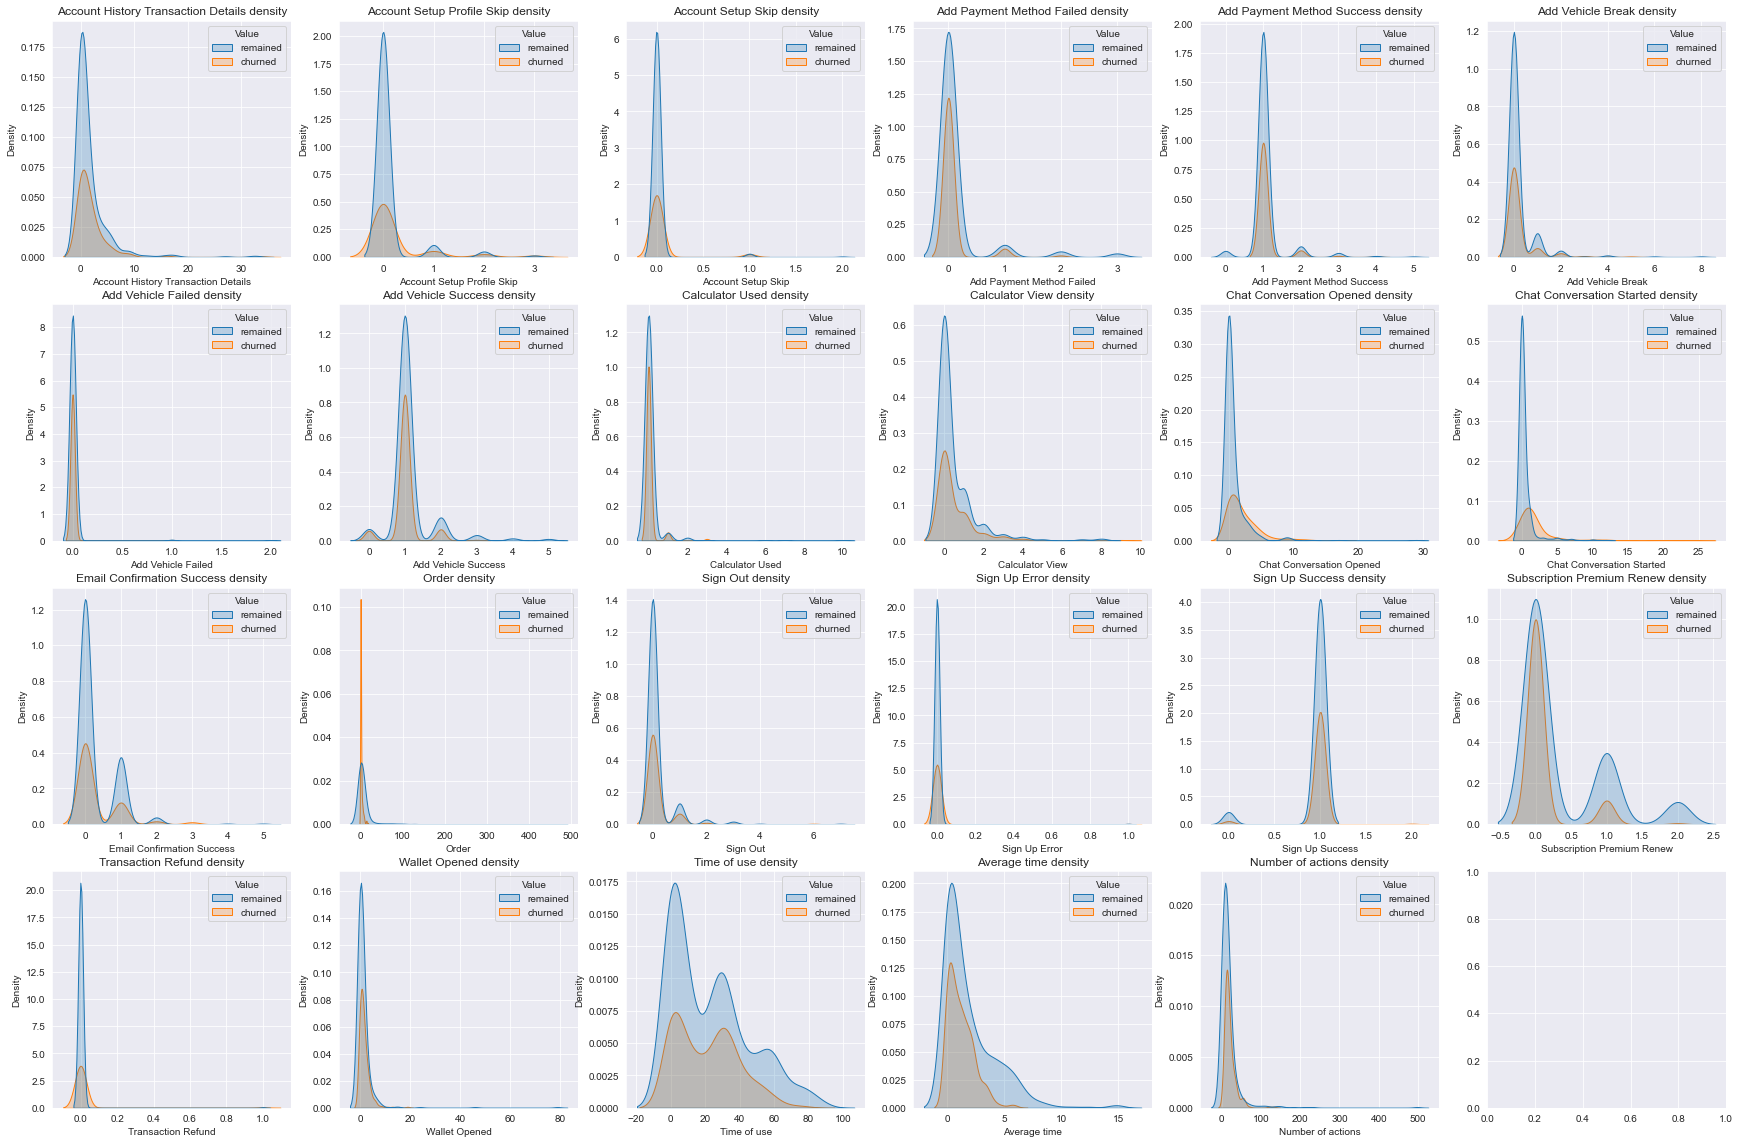

In [6]:
features = ['Account History Transaction Details', 'Account Setup Profile Skip',
       'Account Setup Skip', 'Add Payment Method Failed',
       'Add Payment Method Success', 'Add Vehicle Break', 'Add Vehicle Failed',
       'Add Vehicle Success', 'Calculator Used', 'Calculator View',
       'Chat Conversation Opened', 'Chat Conversation Started',
       'Email Confirmation Success', 'Order', 'Sign Out',
       'Sign Up Error', 'Sign Up Success',
       'Subscription Premium Renew',
       'Transaction Refund', 'Wallet Opened', 'Time of use', 'Average time', 'Number of actions']

sns.set_style('darkgrid')
fig, ax = plt.subplots(4,6, figsize = (30, 20))

for i, val in enumerate(features):
    sns.kdeplot(data, x = val, hue = 'Value', ax = ax[i // 6][i % 6], fill = True).set(title = f'{val} density')


[Text(0.5, 1.0, 'Number of actions completed')]

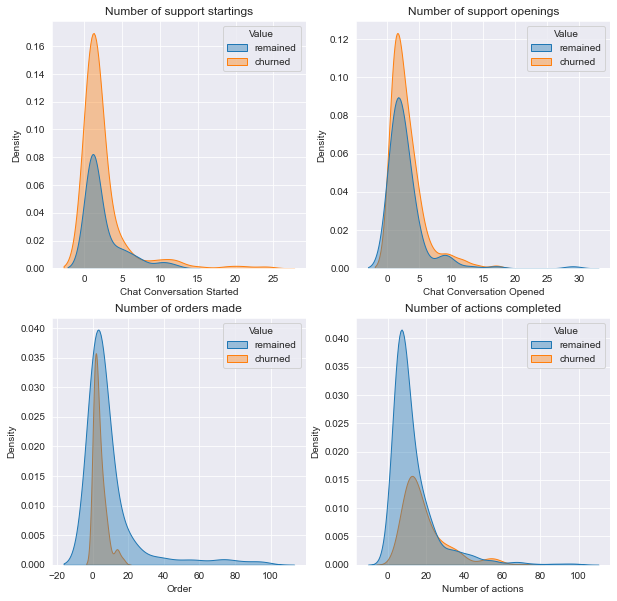

In [7]:
#plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

fig, axes = plt.subplots(2, 2, figsize = (10, 10))

sns.kdeplot(data = data[data['Chat Conversation Started'] > 0], x='Chat Conversation Started', hue = 'Value', fill = True, alpha = 0.4, ax = axes[0, 0]).set(title = 'Number of support startings')
sns.kdeplot(data = data[data['Chat Conversation Opened'] > 0], x='Chat Conversation Opened', hue = 'Value', fill = True, alpha = 0.4, ax = axes[0, 1]).set(title = 'Number of support openings')
sns.kdeplot(data = data[(data['Order'] > 0) & (data['Order'] < 100)], x='Order', hue = 'Value', fill = True, alpha = 0.4, ax = axes[1, 0]).set(title = 'Number of orders made')
sns.kdeplot(data = data[data['Number of actions'] < 100], x='Number of actions', hue = 'Value', fill = True, alpha = 0.4, ax = axes[1, 1]).set(title = 'Number of actions completed')


[Text(0.5, 1.0, 'Phone model')]

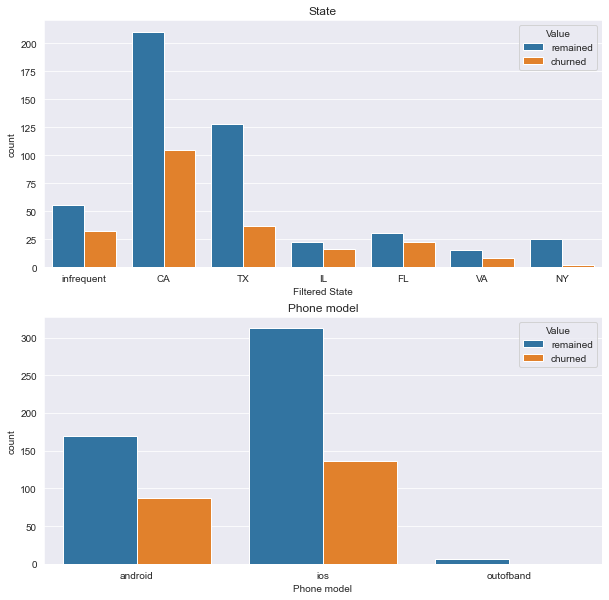

In [8]:
counts = data['State'].value_counts()
good = counts > 20
data['Filtered State'] = data['State'].apply(lambda x : x if good[x] else 'infrequent')

fig, axes = plt.subplots(2, figsize = (10, 10))

sns.countplot(data = data, x='Filtered State', hue = 'Value', ax = axes[0]).set(title = 'State')
sns.countplot(data = data, x='Phone model', hue = 'Value', ax = axes[1]).set(title = 'Phone model')